In [2]:
import numpy as np
import matplotlib.pyplot as plt

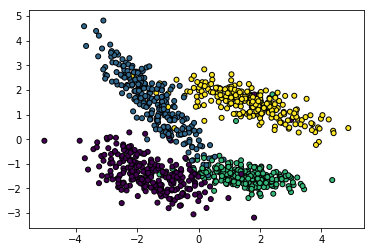

In [3]:
from sklearn.datasets import make_classification

K = 4

X, y = make_classification(n_samples=1000, n_features=2, class_sep=1.5,
                           n_redundant=0, n_informative=2, n_clusters_per_class=1, n_classes=K, random_state=7)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()

In [4]:
def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w

In [5]:
def unpack_params(theta, K):
    W = theta.reshape(K, -1)
    b = W[:, -1]
    W = W[:, :-1]
    return W, b

In [6]:
def predict_sparsemax(theta, X, K, return_log_probs=False):
    W,b = unpack_params(theta, K)
    scores = np.dot(X, W.T) + b.T
    return np.argmax(scores, axis=1)

### [Fenchel-Young Losses](https://arxiv.org/pdf/1805.09717.pdf)

$L(y,s) = \Omega^*(s) + \Omega(y) - s^Ty$

Softmax:

$\Omega(\mu) = \sum_k \mu_k \log \mu_k$

Sparsemax:

$\Omega(\mu) = \frac{1}{2} \|\mu\|^2$

Linear classifier:

$s = Wx + b$

Gradient of the loss function: 

$\nabla_W L = J^T x^T$, where $J$ is the Jacobi matrix of $L$ (as a function of $s$). In the case of sparsemax classifier, $J = \mathrm{sparsemax}(s) - y$. Here, $\mathrm{sparsemax}(s)$ denotes the euclidean projection of the vector $s$ onto the standard simplex and $y$ is one-hot encoding of the class label.

In [7]:
def risk_and_grad(theta, X, Y, alpha):
    
    K = Y.shape[1]
    d = X.shape[1]
    N = X.shape[0]
    
    W,b = unpack_params(theta, K) 
    S = np.dot(X, W.T) + b.T
    
    Mu = np.zeros(S.shape)
    for k in range(S.shape[0]):
        Mu[k,:] = projection_simplex_sort(S[k,:])
    
    risk = np.sum(Mu * S, axis = 1) - 0.5 * np.sum(Mu * Mu, axis = 1)  + 1/2 - np.sum(Y * S, axis = 1)
    risk = np.mean(risk)
    risk += alpha/2 * np.sum(theta**2)
    
    grad_W = alpha * W
    grad_b = alpha * b
    grad_W += 1/N*np.dot((Mu - Y).T, X)
    grad_b += 1/N*np.sum((Mu - Y), axis=0) 
    gradient = np.hstack((grad_W, grad_b[:,np.newaxis]))
    
    return risk, gradient.flatten()

In [8]:
from sklearn.preprocessing import LabelBinarizer
from scipy.optimize import check_grad

N = 10
d = 3 # n_features
K = 5 # n_classes
alpha = 0.1 # regularization constant

X_toy = np.random.randn(N,d)
y_toy = np.arange(N)%K
Y_toy = LabelBinarizer().fit_transform(y_toy) # one-hot encoding of y_toy

func = lambda w: risk_and_grad(w, X_toy, Y_toy, alpha)[0]
grad = lambda w: risk_and_grad(w, X_toy, Y_toy, alpha)[1]

w0 = np.random.randn(K * (d + 1),)
difference = check_grad(func, grad, w0)
print("Difference:  ", difference)

Difference:   1.0404583967132772e-07


In [9]:
from scipy.optimize import minimize

Y = LabelBinarizer().fit_transform(y)
K = Y.shape[1]
d = X.shape[1]

w0 = np.random.randn(K*d+K,)

func = lambda x, *args: risk_and_grad(x, *args)[0]
grad = lambda w, *args: risk_and_grad(w, *args)[1]

theta_opt = minimize(func, w0, args = (X, Y, alpha), method='L-BFGS-B', options={'maxiter': 1000}, jac = grad).x

In [10]:
h = 0.05  # step size in the mesh

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

X_test = np.c_[xx.ravel(), yy.ravel()]

In [11]:
Z = predict_sparsemax(theta_opt, X_test, K).reshape(xx.shape)

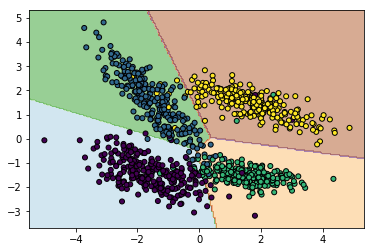

In [12]:
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=.5)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()